In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML

def dambreak_initial(domain):
    cells = len(domain)
    h_up, h_down = np.ones(cells//2), np.ones(cells//2)*0
    h = np.append(h_up, h_down)
    uh = h*0
    U = np.vstack((h,uh))
    return(U)

def initial_profile_1d_analytic(x,h_str,u_str):
    x_, t_ = sp.symbols("x t")
    expr_h  = sp.sympify(h_str)
    expr_u  = sp.sympify(u_str)
    expr_uh = expr_h*expr_u
    h  = sp.lambdify([x_,t_], expr_h,  "numpy")
    u  = sp.lambdify([x_,t_], expr_u,  "numpy")
    uh = sp.lambdify([x_,t_], expr_uh, "numpy")

    if type(u(x,0)) == float:
        y = u(x,0) + x*0 
        U = np.array([y,uh(x,0)])
    else:
        U = np.array([u(x,0),uh(x,0)])
        
    return U

def S_forced_solution_1d(x,t,h_str,u_str):    
    '''input: expr of function h and u 
       output: RHS of the forced solution
    '''
    t = 0
    x_, t_ = sp.symbols("x t")
    g = 9.8

    expr_h = sp.sympify(h_str)
    expr_u = sp.sympify(u_str)
    expr_uh = expr_h*expr_u

    h_t  = sp.diff(expr_h,t_)
    uh_t = sp.diff(expr_uh,t_)
    u_t  = sp.diff(expr_u,t_)

    E_1  = sp.diff(expr_uh, x_)
    E_2  = sp.diff(expr_u**2*expr_h + g*expr_h**2/2, x_)

    S_forced_1 = sp.lambdify([x_,t_], h_t + E_1, "numpy")
    S_forced_2 = sp.lambdify([x_,t_], u_t + E_2, "numpy")
    
    if type(S_forced_1(x,t)) == float:
        Sx1 = S_forced_1(x,t) + x*0 
    else:
        Sx1= S_forced_1(x,t)
    
    if type(S_forced_2(x,t)) == float:
        Sx2 = S_forced_2(x,t) + x*0 
    else:
        Sx2= S_forced_2(x,t)

    S_forced = np.array([Sx1, Sx2])
    return S_forced  

def SWWE_solver_1d(x, 
                   U, 
                   S=[0,0], 
                   forced_solution = 0,
                   ghost=2, 
                   g=9.8, 
                   finaltime = 0.15, 
                   boundary = 'none', 
                   reflective = True,
                   forced = False,
                   play=False):
    '''
    The domain would be a rectangle boundary
    U is the fluxes on x-axes
    forced_solution = h_str, u_str
    '''
    
    time = 0.0
    count = 0
    dx = x[1] - x[0]
    
    if forced_solution != 0:
        forced = True
    
    if forced == True:
        x_, t_ = sp.symbols("x t")
        h_str,u_str = forced_solution
        U_record = np.zeros(len(x)-4)
        
        expr_h = sp.sympify(h_str)
        expr_u = sp.sympify(u_str)
        expr_uh = expr_h*expr_u
        h_forced = sp.lambdify([x_,t_],expr_h,"numpy")
        uh_forced = sp.lambdify([x_,t_],expr_uh,"numpy")
        
        U_forced = initial_profile_1d_analytic(x,h_str,u_str)        
        S = np.array(S_forced_solution_1d(x,0,h_str,u_str))

    fig, axes = plt.subplots()
    axes.plot(x,U[0],'r')

    if play == True:
        camera = Camera(fig)
    
    while (time < finaltime):
        count += 1 
        h, uh = U[0,:], U[1,:]
        u = np.divide(uh,h,out=np.zeros_like(uh),where = h != 0)

        E1 = uh
        E2 = u**2*h + (1/2)*g*h**2
        E = np.vstack((E1,E2))

        U_R, U_L = U[:,1:], U[:,:-1]
        E_R, E_L = E[:,1:], E[:,:-1]
        u_R, u_L = u[1:], u[:-1]         #
        h_R, h_L = h[1:], h[:-1]         # 
        
        a_plus  = np.maximum(np.maximum(u_L + np.sqrt(g*h_L), u_R + np.sqrt(g*h_R)), 0.0*u_L)
        a_minus = np.minimum(np.minimum(u_L - np.sqrt(g*h_L), u_R - np.sqrt(g*h_R)), 0.0*u_L)

        dt  = (dx)/max(np.max(a_plus),np.max(-a_minus))
        time += dt

        np.seterr(divide='warn')
        E_HLL = np.divide((a_plus * E_L - a_minus * E_R)+ a_plus*a_minus*(U_R - U_L),
                          (a_plus- a_minus),
                          out=np.zeros_like((a_plus * E_L - a_minus * E_R)+ a_plus*a_minus*(U_R - U_L)),
                          where = a_plus - a_minus != 0)

        E_R, E_L = E_HLL[:,1:], E_HLL[:,:-1]
        
        if forced==True:
            U[:,1:-1] -= dt/dx*(E_R - E_L) + dt*S[:,1:-1]
            S = np.array(S_forced_solution_1d(x,time,h_str,u_str))
            
            print('=======',count,". time:",time,"======")
            
        else:
            U[:,1:-1] -= dt/dx*(E_R - E_L)  
        
        if reflective == True:
            U[1,-2] = -U[1,-2]   
            U[1,1] = -U[1,1]
        
        
        if forced == True:
            U_record = np.vstack((U_record,U[1,2:-2]))
                    
        if play == True:
            axes.plot(x[3:-3],U[0,3:-3],'b')
            camera.snap()


    plt.close('all')
    
    print("play: ",play)
    print("forced: ",forced)


    print("It's done.  Time step=",count)
    if play == True:
        animation = camera.animate(blit=False, interval=10)
        play = HTML(animation.to_html5_video())
        
    
    if forced == True:
        return (U, E, U_record, count, play)
    else:
        return U, E, play 

## Dambreak Problem

In [5]:
def dambreak_initial(domain):
    cells = len(domain)
    h_up, h_down = np.ones(cells//2), np.ones(cells//2)*0
    h = np.append(h_up, h_down)
    uh = h*0
    U = np.vstack((h,uh))
    return(U)

x = np.linspace(-2, 2, 400)
U = dambreak_initial(x)
U, E, play = SWWE_solver_1d(x,U, finaltime=0.2, forced=False, play=False)


play:  False
forced:  False
It's done.  Time step= 106


In [3]:
play

False

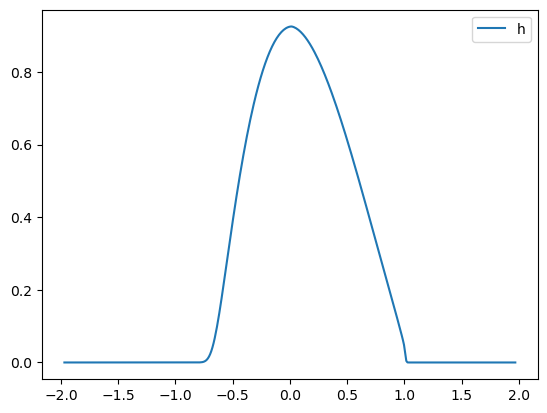

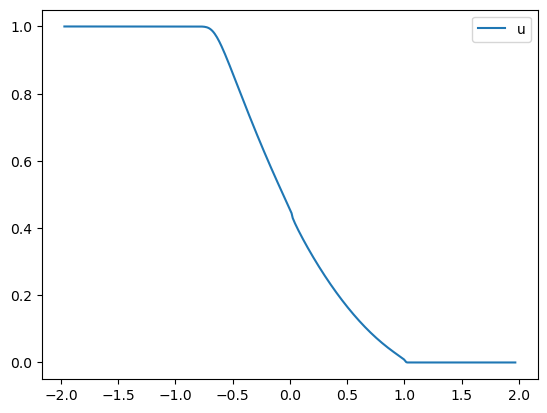

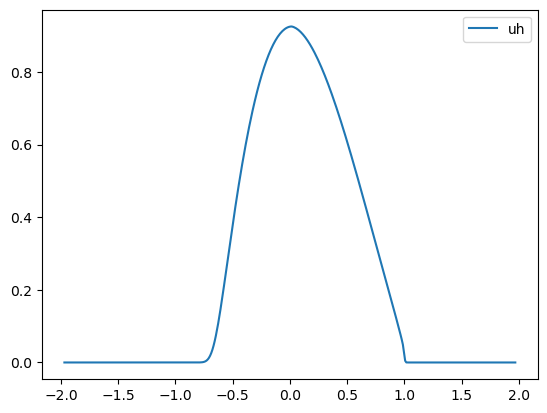

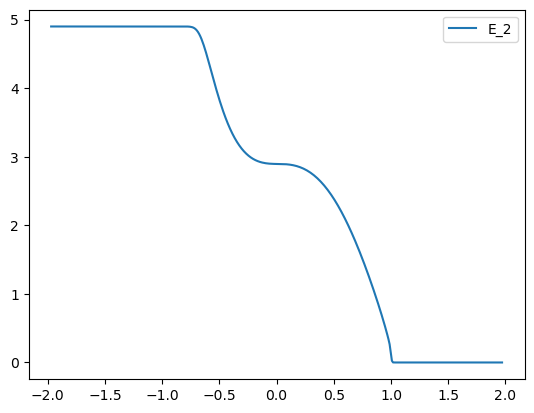

In [4]:
u, h = U
uh, E2 = E
plt.plot(x[3:-3],h[3:-3],label="h")
plt.legend()
plt.show()

plt.plot(x[3:-3],u[3:-3],label="u")    
plt.legend()
plt.show()
plt.plot(x[3:-3],uh[3:-3],label="uh")    
plt.legend()
plt.show()


plt.plot(x[3:-3],E2[3:-3],label="E_2")    
plt.legend()
plt.show()

## Dambreak Problem with Forced Solution

In [4]:
h_str = 'exp(((x+0.5)/2)**2)'
u_str = '0.5*exp(0*x)'
forced_sol = h_str,u_str

x = np.linspace(-2, 2, 400)


U = initial_profile_1d_analytic(x,h_str,u_str)

U, E, U_record, count, play = SWWE_solver_1d(x,U, forced_solution = forced_sol, finaltime=0.2, play=True)

======= 1 . time: 0.00143536547983508 ======
======= 2 . time: 0.00287073095967016 ======
======= 3 . time: 0.00430609643950524 ======
======= 4 . time: 0.00574146191934032 ======
======= 5 . time: 0.0071768273991753995 ======
======= 6 . time: 0.00861219287901048 ======
======= 7 . time: 0.01004755835884556 ======
======= 8 . time: 0.011482923838680641 ======
======= 9 . time: 0.012918289318515722 ======
======= 10 . time: 0.014353654798350803 ======
======= 11 . time: 0.01578902027818588 ======
======= 12 . time: 0.01722438575802096 ======
======= 13 . time: 0.01848153488656996 ======
======= 14 . time: 0.01898166865758001 ======
======= 15 . time: 0.019176592213049577 ======
======= 16 . time: 0.019310221951651663 ======
======= 17 . time: 0.019445370613132732 ======
======= 18 . time: 0.01957046951563876 ======
======= 19 . time: 0.0196970505088835 ======
======= 20 . time: 0.01981550678926357 ======
======= 21 . time: 0.01993486179140599 ======
======= 22 . time: 0.020047517879008

/var/folders/8l/nxqrxvb13_z8rc5xy8mlh_tr0000gn/T/ipykernel_10938/3703775965.py:125: RuntimeWarning: invalid value encountered in sqrt
  a_plus  = np.maximum(np.maximum(u_L + np.sqrt(g*h_L), u_R + np.sqrt(g*h_R)), 0.0*u_L)
/var/folders/8l/nxqrxvb13_z8rc5xy8mlh_tr0000gn/T/ipykernel_10938/3703775965.py:126: RuntimeWarning: invalid value encountered in sqrt
  a_minus = np.minimum(np.minimum(u_L - np.sqrt(g*h_L), u_R - np.sqrt(g*h_R)), 0.0*u_L)


In [6]:
play

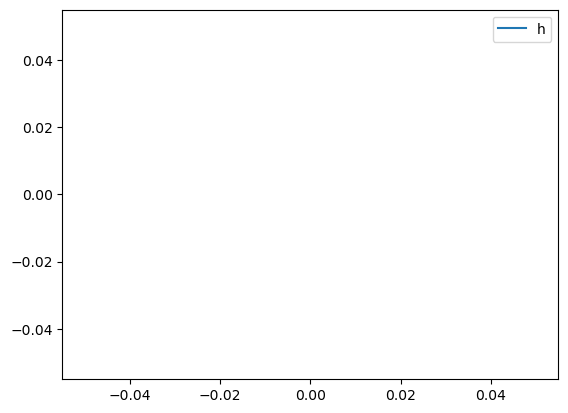

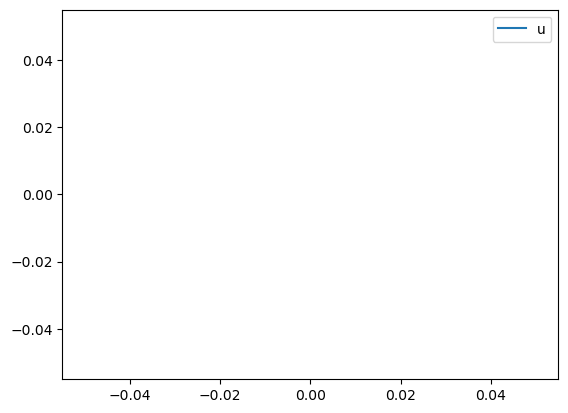

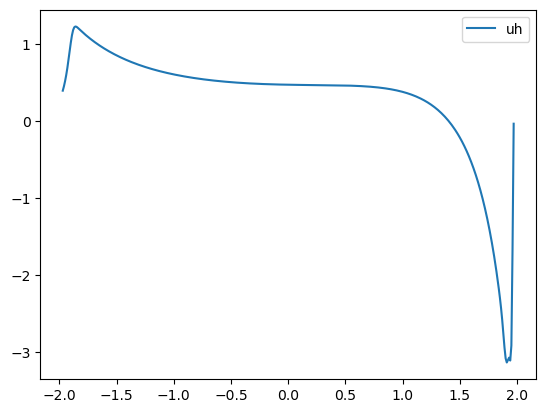

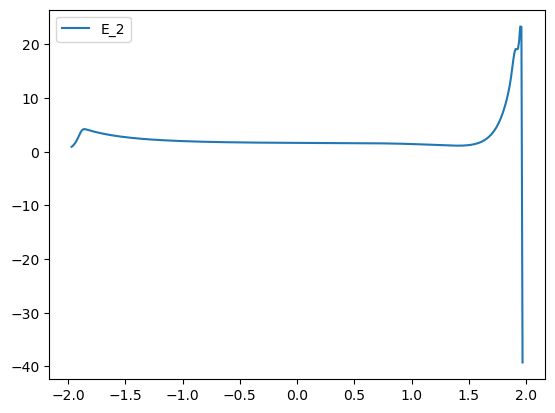

In [7]:
u, h = U
uh, E2 = E
plt.plot(x[3:-3],h[3:-3],label="h")
plt.legend()
plt.show()

plt.plot(x[3:-3],u[3:-3],label="u")    
plt.legend()
plt.show()

plt.plot(x[3:-3],uh[3:-3],label="uh")    
plt.legend()
plt.show()


plt.plot(x[3:-3],E2[3:-3],label="E_2")    
plt.legend()
plt.show()

In [8]:
h_str = 'exp(((x+0.5)/2)**2)'
u_str = '0.5*exp(0)'
forced_sol = h_str,u_str

x = np.linspace(-2, 2, 400)
U = dambreak_initial(x)
Sforced = S_forced_solution_1d(x,1,h_str,u_str)

In [9]:
plt.plot(x,Sforced[1])

In [10]:
np.shape(Sforced)

(2, 400)

In [11]:
U = initial_profile_1d_analytic(x,h_str,u_str)